<div align="center">
<p align="center" style="width: 100%;">
    <img src="https://raw.githubusercontent.com/vlm-run/.github/refs/heads/main/profile/assets/vlm-black.svg" alt="VLM Run Logo" width="80" style="margin-bottom: -5px; color: #2e3138; vertical-align: middle; padding-right: 5px;"><br>
</p>
<p align="center"><a href="https://docs.vlm.run"><b>Website</b></a> | <a href="https://docs.vlm.run/"><b>API Docs</b></a> | <a href="https://docs.vlm.run/blog"><b>Blog</b></a> | <a href="https://discord.gg/AMApC2UzVY"><b>Discord</b></a> | <a href="https://chat.vlm.run"><b>Chat</b></a>
</p>
</div>

# VLM Run Orion - Professional Headshot Generation with Camera Angles

This comprehensive cookbook demonstrates how to generate professional headshots using [VLM Run Orion's](https://vlm.run/orion) image generation capabilities with various camera angles and perspectives. For more details on the API, see the [Agent API docs](https://docs.vlm.run/agents/introduction).

For this notebook, we'll cover how to use the **VLM Run Agent Chat Completions API** to generate professional headshots from a source image using 19 different camera angles and perspectives.

We'll cover the following camera angles:
 1. Long Shot (Establishing Shot)
 2. Medium Shot (Medium Close-Up)
 3. Close-Up Shot (Extreme Close-Up)
 4. Point of View Shot (POV)
 5. Cowboy Angle
 6. Hip Level Shot
 7. Knee Level Shot
 8. Tracking Shot (Truck Shot)
 9. Shoulder Level Shot
 10. Telephoto Perspective (Zoom Shot)
 11. Macro Perspective
 12. Wide-Angle Perspective
 13. Dutch Angle (Tilted Shot)
 14. Low Angle
 15. Worm's Eye View
 16. High Angle
 17. Bird's Eye View
 18. Eye-Level Shot
 19. Pedestal Shot

## Prerequisites

- Python 3.10+
- VLM Run API key (get one at [app.vlm.run](https://app.vlm.run))
- VLM Run Python Client with OpenAI extra `vlmrun[openai]`
- A source image for headshot generation


## Setup

First, install the required packages and configure the environment.


In [115]:
# Install required packages
%pip install vlmrun[openai] --upgrade --quiet
%pip install cachetools pillow requests numpy --quiet


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [116]:
import os
import getpass

VLMRUN_API_KEY = os.getenv("VLMRUN_API_KEY", None)
if VLMRUN_API_KEY is None:
    VLMRUN_API_KEY = getpass.getpass("Enter your VLM Run API key: ")


## Initialize the VLM Run Client

We use the OpenAI-compatible chat completions interface through the VLM Run SDK.


In [117]:
from vlmrun.client import VLMRun

BASE_URL = os.getenv("VLMRUN_BASE_URL", "https://agent.vlm.run/v1")
client = VLMRun(api_key=VLMRUN_API_KEY, base_url=BASE_URL)
print("VLM Run client initialized successfully!")
print(f"Base URL: {BASE_URL}")


VLM Run client initialized successfully!
Base URL: https://agent.vlm.run/v1


## Helper Functions

We create helper functions to simplify making chat completion requests with structured outputs for image generation.


In [118]:
import hashlib
import json
from typing import Any, Type, TypeVar
from pathlib import Path

import cachetools
from pydantic import BaseModel, Field
from PIL import Image
from IPython.display import HTML, display
from vlmrun.common.image import encode_image
from vlmrun.types import ImageRef, UrlRef


T = TypeVar('T', bound=BaseModel)


def display_images(images: Image.Image | list[Image.Image], texts: list[str] | None = None, width: int = 400):
    """Display images with optional captions."""
    if isinstance(images, Image.Image):
        images = [images]
    if texts is None:
        texts = [None] * len(images)
    elif isinstance(texts, str):
        texts = [texts]
    elif len(texts) != len(images):
        raise ValueError("`texts` must be a list of the same length as `images`")

    imgs_html = ""
    for image, text in zip(images, texts):
        W, H = image.size
        if W > width:
            H = int(H * width / W)
            W = width
            image = image.resize((W, H))
        im_bytes = encode_image(image, format="JPEG")
        imgs_html += f"<div style='display:inline-block; margin:5px; text-align:center'>"
        imgs_html += f"<img src='{im_bytes}' style='width:{width}px; border-radius:6px'>"
        if text:
            imgs_html += f"<div style='font-size:12px; color:#f0f0f0; margin-top:5px'>{text}</div>"
        imgs_html += f"</div>"
    return display(HTML(f"<div style='display:flex; flex-wrap:wrap'>{imgs_html}</div>"))


def custom_key(prompt: str, images: list[str] | list[Image.Image] | None = None, response_model: Type[T] | None = None, model: str = "vlmrun-orion-1:auto"):
    """Custom key for caching chat_completion."""
    image_keys = []
    if images:
        for image in images:
            if isinstance(image, Image.Image):
                thumb = image.copy()
                thumb.thumbnail((128, 128))
                encoded = encode_image(thumb, format="JPEG")
                image_keys.append(encoded)
            elif isinstance(image, str):
                image_keys.append(image)
    image_keys = tuple(image_keys)
    response_key = hashlib.sha256(json.dumps(response_model.model_json_schema(), sort_keys=True).encode()).hexdigest() if response_model else ""
    return (prompt, image_keys, response_key, model)


@cachetools.cached(cache=cachetools.TTLCache(maxsize=1000, ttl=3600), key=custom_key)
def chat_completion(
    prompt: str,
    images: list[str] | list[Image.Image] | None = None,
    response_model: Type[T] | None = None,
    model: str = "vlmrun-orion-1:fast"
) -> tuple[str | BaseModel, str]:
    """
    Make a chat completion request with optional images and structured output.

    Args:
        prompt: The text prompt/instruction
        images: List of image URLs or PIL Image objects to process
        response_model: Optional Pydantic model for structured output
        model: Model to use (default: vlmrun-orion-1:fast)

    Returns:
        Parsed response model if response_model provided, else raw response text
    """
    content = []
    content.append({"type": "text", "text": prompt})

    if images:
        for image in images:
            if isinstance(image, Image.Image):
                image = encode_image(image, format="JPEG")
                content.append({"type": "image_url", "image_url": {"url": image}})
            elif isinstance(image, str):
                assert image.startswith("http"), "Image URLs must start with http or https"
                content.append({"type": "image_url", "image_url": {"url": image}})
            else:
                raise ValueError(f"Invalid image type: {type(image)}")

    kwargs = {
        "model": model,
        "messages": [{"role": "user", "content": content}]
    }

    if response_model:
        kwargs["response_format"] = {
            "type": "json_schema",
            "schema": response_model.model_json_schema()
        }

    response = client.agent.completions.create(**kwargs)
    response_text = response.choices[0].message.content

    if response_model:
        return response_model.model_validate_json(response_text), response.session_id

    return response_text, response.session_id

print("Helper functions defined!")


Helper functions defined!


## Professional Headshot Generation with Camera Angles

VLM Run agents can generate professional headshots from source images using various camera angles and perspectives. Each angle creates a different visual effect and conveys different emotions or professional contexts.


### Load Source Image

First, let's load the source image that we'll use to generate headshots with different camera angles.



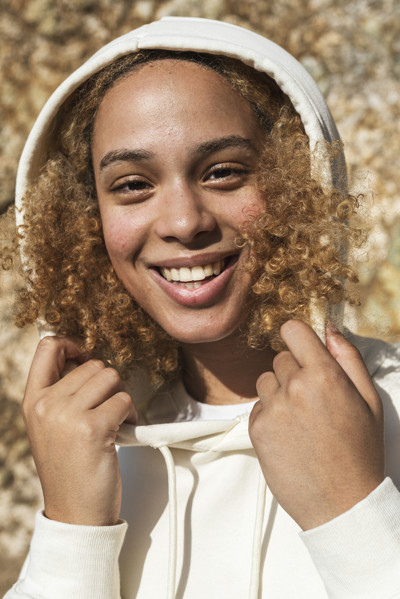

In [119]:
import requests
from io import BytesIO
from PIL import Image

# Load source image from URL or file path
SOURCE_IMAGE_URL = "https://storage.googleapis.com/vlm-data-public-prod/hub/examples/agent_use_cases/Headshot/candid_image.jpg"

# Load image from URL
if SOURCE_IMAGE_URL.startswith("http"):
    response = requests.get(SOURCE_IMAGE_URL)
    source_image = Image.open(BytesIO(response.content))
else:
    # Load from local file path
    source_image = Image.open(SOURCE_IMAGE_URL)

# Display the source image
display_images([source_image], texts=["Source Image"], width=400)

SOURCE_IMAGE = SOURCE_IMAGE_URL  


### Response Model for Generated Headshots

We'll use a structured response model to get the generated headshot images.


In [120]:
class GeneratedHeadshotResponse(BaseModel):
    """Response model for generated headshot."""
    image: ImageRef | UrlRef = Field(..., description="The generated professional headshot image")
    description: str = Field(default="", description="Description of the generated headshot")

print("Response model defined!")


Response model defined!


### 1. Long Shot (Establishing Shot)

A long shot shows the full body or most of the body, providing context and establishing the subject in their environment. This is useful for professional portraits that need to show the person in their workspace or environment.


>> RESPONSE
Generated headshot: id='img_09c7cc'
Description: Generated a professional headshot using a Long Shot camera angle, showing the subject in a professional environment with appropriate lighting and composition.

>> GENERATED HEADSHOT - Long Shot



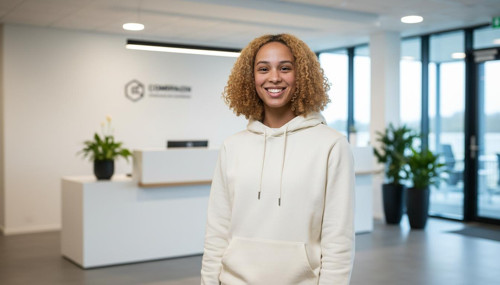

In [121]:
result, session_id = chat_completion(
    prompt="Generate a professional headshot using a Long Shot (Establishing Shot) camera angle. The image should show the full body or most of the body, providing context and establishing the subject in their professional environment. Maintain professional lighting and composition.",
    images=[SOURCE_IMAGE_URL],
    response_model=GeneratedHeadshotResponse,
    model="vlmrun-orion-1:fast"
)

print(">> RESPONSE")
print(f"Generated headshot: {result.image}")
print(f"Description: {result.description}")

if hasattr(result.image, 'id'):
    image_path = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    if isinstance(image_path, Image.Image):
        generated_image = image_path
    else:
        generated_image = Image.open(image_path)
else:
    response = requests.get(result.image.url)
    generated_image = Image.open(BytesIO(response.content))
print(f"\n>> GENERATED HEADSHOT - Long Shot")
display_images([generated_image], texts=["1. Long Shot (Establishing Shot)"], width=500)


### 2. Medium Shot (Medium Close-Up)

A medium shot frames the subject from the waist up, creating a balanced composition that shows both the face and upper body. This is one of the most common professional headshot angles.


>> RESPONSE
Generated headshot: id='img_f13a36'
Description: Here is your professional headshot, img_f13a36, using a Medium Shot camera angle, framed from the waist up, with professional lighting and a confident and approachable expression.

>> GENERATED HEADSHOT - Medium Shot



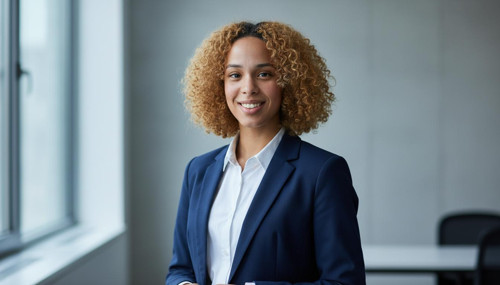

In [122]:
result, session_id = chat_completion(
    prompt="Generate a professional headshot using a Medium Shot (Medium Close-Up) camera angle. Frame the subject from the waist up, creating a balanced composition that shows both the face and upper body. Use professional lighting and ensure the subject looks confident and approachable.",
    images=[SOURCE_IMAGE_URL],
    response_model=GeneratedHeadshotResponse,
    model="vlmrun-orion-1:fast"
)

print(">> RESPONSE")
print(f"Generated headshot: {result.image}")
print(f"Description: {result.description}")

if hasattr(result.image, 'id'):
    image_path = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    if isinstance(image_path, Image.Image):
        generated_image = image_path
    else:
        generated_image = Image.open(image_path)
else:
    response = requests.get(result.image.url)
    generated_image = Image.open(BytesIO(response.content))
print(f"\n>> GENERATED HEADSHOT - Medium Shot")
display_images([generated_image], texts=["2. Medium Shot (Medium Close-Up)"], width=500)


### 3. Close-Up Shot (Extreme Close-Up)

A close-up shot focuses tightly on the face, capturing facial expressions and details. This creates an intimate and engaging professional headshot that emphasizes the subject's features.


>> RESPONSE
Generated headshot: id='img_4e0fed'
Description: Here is a professional headshot generated from your image, with an extreme close-up to emphasize facial features and professional lighting.

>> GENERATED HEADSHOT - Close-Up Shot



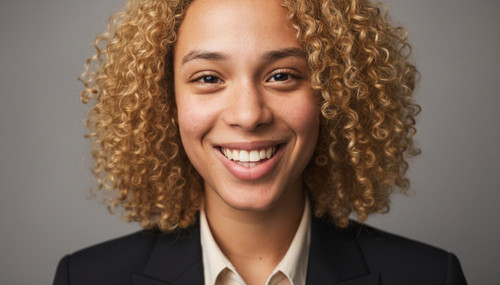

In [123]:
result, session_id = chat_completion(
    prompt="Generate a professional headshot using a Close-Up Shot (Extreme Close-Up) camera angle. Focus tightly on the face, capturing facial expressions and details. Create an intimate and engaging professional headshot that emphasizes the subject's features with professional lighting.",
    images=[SOURCE_IMAGE_URL],
    response_model=GeneratedHeadshotResponse,
    model="vlmrun-orion-1:fast"
)

print(">> RESPONSE")
print(f"Generated headshot: {result.image}")
print(f"Description: {result.description}")

if hasattr(result.image, 'id'):
    image_path = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    if isinstance(image_path, Image.Image):
        generated_image = image_path
    else:
        generated_image = Image.open(image_path)
else:
    response = requests.get(result.image.url)
    generated_image = Image.open(BytesIO(response.content))
print(f"\n>> GENERATED HEADSHOT - Close-Up Shot")
display_images([generated_image], texts=["3. Close-Up Shot (Extreme Close-Up)"], width=500)


### 4. Point of View Shot (POV)

A POV shot shows the perspective as if the viewer is looking through the subject's eyes or from their viewpoint. This creates a unique and immersive professional headshot.


>> RESPONSE
Generated headshot: id='img_01792b'
Description: I've generated a professional headshot from a POV camera angle, making it appear as though the viewer is seeing through the subject's eyes. The subject maintains a professional style and an approachable expression against a clean, modern background with optimal lighting for a professional profile.

>> GENERATED HEADSHOT - Point of View Shot



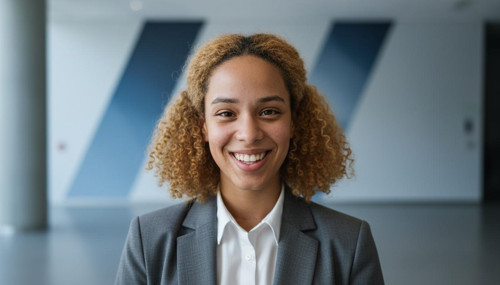

In [124]:
result, session_id = chat_completion(
    prompt="Generate a professional headshot using a Point of View Shot (POV) camera angle. Show the perspective as if the viewer is looking through the subject's eyes or from their viewpoint. Create a unique and immersive professional headshot with appropriate professional styling.",
    images=[SOURCE_IMAGE_URL],
    response_model=GeneratedHeadshotResponse,
    model="vlmrun-orion-1:fast"
)

print(">> RESPONSE")
print(f"Generated headshot: {result.image}")
print(f"Description: {result.description}")

if hasattr(result.image, 'id'):
    image_path = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    if isinstance(image_path, Image.Image):
        generated_image = image_path
    else:
        generated_image = Image.open(image_path)
else:
    response = requests.get(result.image.url)
    generated_image = Image.open(BytesIO(response.content))
print(f"\n>> GENERATED HEADSHOT - Point of View Shot")
display_images([generated_image], texts=["4. Point of View Shot (POV)"], width=500)


### 5. Cowboy Angle

A cowboy angle frames the subject from mid-thigh up, named after its use in Western films. This angle provides a strong, confident look that's great for professional headshots.


>> RESPONSE
Generated headshot: id='img_b17b1a'
Description: Here is your professional headshot, framed from mid-thigh up with a Cowboy Angle, conveying a strong and confident look. Let me know if you would like any adjustments!

>> GENERATED HEADSHOT - Cowboy Angle



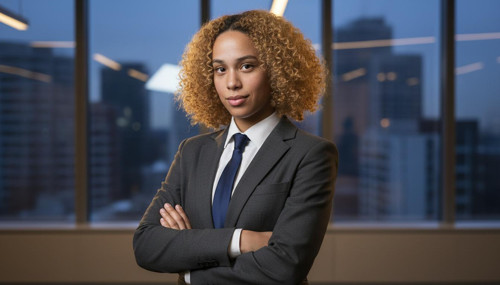

In [125]:
result, session_id = chat_completion(
    prompt="Generate a professional headshot using a Cowboy Angle camera angle. Frame the subject from mid-thigh up, creating a strong and confident look. This angle should convey authority and professionalism with appropriate lighting and composition.",
    images=[SOURCE_IMAGE_URL],
    response_model=GeneratedHeadshotResponse,
    model="vlmrun-orion-1:fast"
)

print(">> RESPONSE")
print(f"Generated headshot: {result.image}")
print(f"Description: {result.description}")

if hasattr(result.image, 'id'):
    image_path = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    if isinstance(image_path, Image.Image):
        generated_image = image_path
    else:
        generated_image = Image.open(image_path)
else:
    response = requests.get(result.image.url)
    generated_image = Image.open(BytesIO(response.content))
print(f"\n>> GENERATED HEADSHOT - Cowboy Angle")
display_images([generated_image], texts=["5. Cowboy Angle"], width=500)


### 6. Hip Level Shot

A hip level shot frames the subject from the hip up, providing a natural and approachable perspective that's excellent for professional headshots.


>> RESPONSE
Generated headshot: id='img_d3d1b2'
Description: Here is your professional headshot, framed from the hip up with a Hip Level Shot camera angle, and professional lighting to create a welcoming and professional appearance.

>> GENERATED HEADSHOT - Hip Level Shot



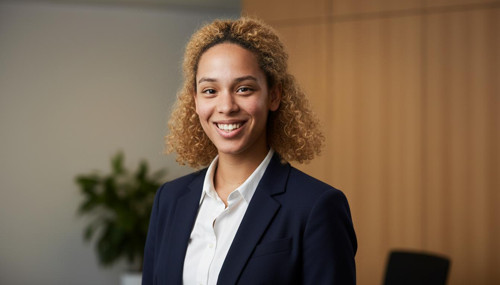

In [126]:
result, session_id = chat_completion(
    prompt="Generate a professional headshot using a Hip Level Shot camera angle. Frame the subject from the hip up, providing a natural and approachable perspective. Use professional lighting to create a welcoming and professional appearance.",
    images=[SOURCE_IMAGE_URL],
    response_model=GeneratedHeadshotResponse,
    model="vlmrun-orion-1:fast"
)

print(">> RESPONSE")
print(f"Generated headshot: {result.image}")
print(f"Description: {result.description}")

if hasattr(result.image, 'id'):
    image_path = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    if isinstance(image_path, Image.Image):
        generated_image = image_path
    else:
        generated_image = Image.open(image_path)
else:
    response = requests.get(result.image.url)
    generated_image = Image.open(BytesIO(response.content))
print(f"\n>> GENERATED HEADSHOT - Hip Level Shot")
display_images([generated_image], texts=["6. Hip Level Shot"], width=500)


### 7. Knee Level Shot

A knee level shot frames the subject from the knees up, offering a slightly wider view while still maintaining focus on the upper body and face.


>> RESPONSE
Generated headshot: id='img_d9c0fd'
Description: Here is your professional headshot, framed from the knees up, with professional composition and lighting. The original clothing and expression were maintained.

>> GENERATED HEADSHOT - Knee Level Shot



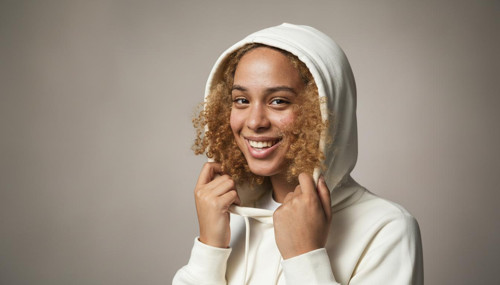

In [127]:
result, session_id = chat_completion(
    prompt="Generate a professional headshot using a Knee Level Shot camera angle. Frame the subject from the knees up, offering a slightly wider view while still maintaining focus on the upper body and face. Ensure professional composition and lighting.",
    images=[SOURCE_IMAGE_URL],
    response_model=GeneratedHeadshotResponse,
    model="vlmrun-orion-1:fast"
)

print(">> RESPONSE")
print(f"Generated headshot: {result.image}")
print(f"Description: {result.description}")

if hasattr(result.image, 'id'):
    image_path = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    if isinstance(image_path, Image.Image):
        generated_image = image_path
    else:
        generated_image = Image.open(image_path)
else:
    response = requests.get(result.image.url)
    generated_image = Image.open(BytesIO(response.content))
print(f"\n>> GENERATED HEADSHOT - Knee Level Shot")
display_images([generated_image], texts=["7. Knee Level Shot"], width=500)


### 8. Tracking Shot (Truck Shot)

A tracking shot involves moving the camera horizontally while following the subject. For a headshot, this creates a dynamic sense of movement and energy.


>> RESPONSE
Generated headshot: id='img_55131d'
Description: Here is your professional headshot generated with a tracking shot camera angle, conveying dynamic movement and confidence, with modern styling.

>> GENERATED HEADSHOT - Tracking Shot



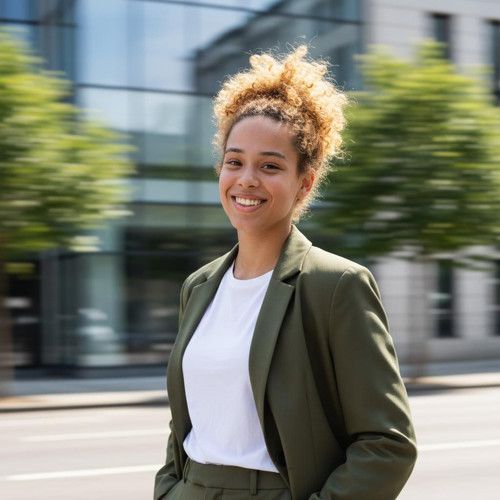

In [128]:
result, session_id = chat_completion(
    prompt="Generate a professional headshot using a Tracking Shot (Truck Shot) camera angle. Create a sense of dynamic movement and energy by simulating a horizontal camera movement. The subject should appear confident and in motion, suitable for a professional headshot with modern styling.",
    images=[SOURCE_IMAGE_URL],
    response_model=GeneratedHeadshotResponse,
    model="vlmrun-orion-1:fast"
)

print(">> RESPONSE")
print(f"Generated headshot: {result.image}")
print(f"Description: {result.description}")

if hasattr(result.image, 'id'):
    image_path = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    if isinstance(image_path, Image.Image):
        generated_image = image_path
    else:
        generated_image = Image.open(image_path)
else:
    response = requests.get(result.image.url)
    generated_image = Image.open(BytesIO(response.content))
print(f"\n>> GENERATED HEADSHOT - Tracking Shot")
display_images([generated_image], texts=["8. Tracking Shot (Truck Shot)"], width=500)


### 9. Shoulder Level Shot

A shoulder level shot frames the subject from the shoulders up, creating an intimate and focused professional headshot that emphasizes facial features.


>> RESPONSE
Generated headshot: id='img_652b50'
Description: Here is the professional headshot based on your request. I used the provided image as a reference and generated a shoulder-level shot with professional lighting to emphasize the subject's facial features.

>> GENERATED HEADSHOT - Shoulder Level Shot



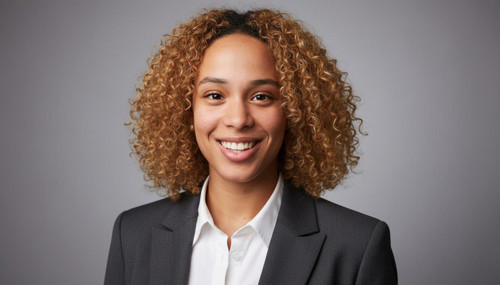

In [129]:
result, session_id = chat_completion(
    prompt="Generate a professional headshot using a Shoulder Level Shot camera angle. Frame the subject from the shoulders up, creating an intimate and focused professional headshot that emphasizes facial features. Use professional lighting to highlight the subject's best qualities.",
    images=[SOURCE_IMAGE_URL],
    response_model=GeneratedHeadshotResponse,
    model="vlmrun-orion-1:fast"
)

print(">> RESPONSE")
print(f"Generated headshot: {result.image}")
print(f"Description: {result.description}")

if hasattr(result.image, 'id'):
    image_path = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    if isinstance(image_path, Image.Image):
        generated_image = image_path
    else:
        generated_image = Image.open(image_path)
else:
    response = requests.get(result.image.url)
    generated_image = Image.open(BytesIO(response.content))
print(f"\n>> GENERATED HEADSHOT - Shoulder Level Shot")
display_images([generated_image], texts=["9. Shoulder Level Shot"], width=500)


### 10. Telephoto Perspective (Zoom Shot)

A telephoto perspective uses a long focal length to compress the background and create a shallow depth of field, making the subject stand out prominently.


>> RESPONSE
Generated headshot: id='img_6bfc5f'
Description: I have generated a professional headshot of the person from the provided image, utilizing a telephoto perspective. The background is beautifully blurred to create a shallow depth of field, ensuring the subject stands out sharply and prominently. Please find the generated headshot below.

>> GENERATED HEADSHOT - Telephoto Perspective



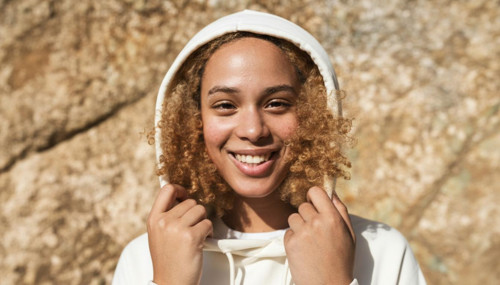

In [130]:
result, session_id = chat_completion(
    prompt="Generate a professional headshot using a Telephoto Perspective (Zoom Shot) camera angle. Use a long focal length effect to compress the background and create a shallow depth of field, making the subject stand out prominently. The background should be beautifully blurred while the subject remains sharp and in focus.",
    images=[SOURCE_IMAGE_URL],
    response_model=GeneratedHeadshotResponse,
    model="vlmrun-orion-1:fast"
)

print(">> RESPONSE")
print(f"Generated headshot: {result.image}")
print(f"Description: {result.description}")

if hasattr(result.image, 'id'):
    image_path = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    if isinstance(image_path, Image.Image):
        generated_image = image_path
    else:
        generated_image = Image.open(image_path)
else:
    response = requests.get(result.image.url)
    generated_image = Image.open(BytesIO(response.content))
print(f"\n>> GENERATED HEADSHOT - Telephoto Perspective")
display_images([generated_image], texts=["10. Telephoto Perspective (Zoom Shot)"], width=500)


### 11. Macro Perspective

A macro perspective uses extreme close-up photography to capture fine details, creating a unique and artistic professional headshot that highlights textures and features.


>> RESPONSE
Generated headshot: id='img_75b4ce'
Description: Here is the professional headshot using a macro perspective and extreme close-up photography, highlighting textures and facial features while maintaining professional quality.

>> GENERATED HEADSHOT - Macro Perspective



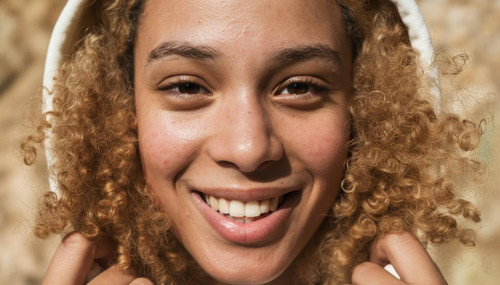

In [131]:
result, session_id = chat_completion(
    prompt="Generate a professional headshot using a Macro Perspective camera angle. Use extreme close-up photography to capture fine details, creating a unique and artistic professional headshot that highlights textures and facial features. Maintain professional quality while showcasing intricate details.",
    images=[SOURCE_IMAGE_URL],
    response_model=GeneratedHeadshotResponse,
    model="vlmrun-orion-1:fast"
)

print(">> RESPONSE")
print(f"Generated headshot: {result.image}")
print(f"Description: {result.description}")

if hasattr(result.image, 'id'):
    image_path = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    if isinstance(image_path, Image.Image):
        generated_image = image_path
    else:
        generated_image = Image.open(image_path)
else:
    response = requests.get(result.image.url)
    generated_image = Image.open(BytesIO(response.content))
print(f"\n>> GENERATED HEADSHOT - Macro Perspective")
display_images([generated_image], texts=["11. Macro Perspective"], width=500)


### 12. Wide-Angle Perspective

A wide-angle perspective uses a short focal length to capture more of the scene, creating a sense of space and context around the subject.


>> RESPONSE
Generated headshot: id='img_e03019'
Description: Here is the professional headshot generated with a wide-angle perspective and short focal length, incorporating elements of the professional environment while keeping the subject as the focal point.

>> GENERATED HEADSHOT - Wide-Angle Perspective



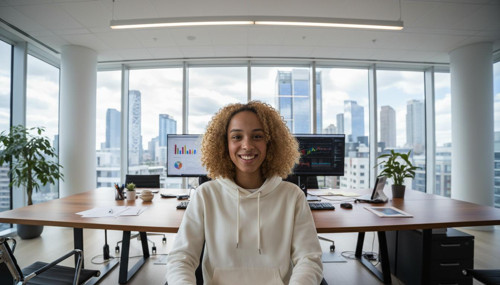

In [132]:
result, session_id = chat_completion(
    prompt="Generate a professional headshot using a Wide-Angle Perspective camera angle. Use a short focal length effect to capture more of the scene, creating a sense of space and context around the subject. The subject should remain the focal point while showing their professional environment.",
    images=[SOURCE_IMAGE_URL],
    response_model=GeneratedHeadshotResponse,
    model="vlmrun-orion-1:fast"
)

print(">> RESPONSE")
print(f"Generated headshot: {result.image}")
print(f"Description: {result.description}")

if hasattr(result.image, 'id'):
    image_path = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    if isinstance(image_path, Image.Image):
        generated_image = image_path
    else:
        generated_image = Image.open(image_path)
else:
    response = requests.get(result.image.url)
    generated_image = Image.open(BytesIO(response.content))
print(f"\n>> GENERATED HEADSHOT - Wide-Angle Perspective")
display_images([generated_image], texts=["12. Wide-Angle Perspective"], width=500)


### 13. Dutch Angle (Tilted Shot)

A Dutch angle tilts the camera to create a dynamic and slightly disorienting effect, adding energy and modern flair to a professional headshot.


>> RESPONSE
Generated headshot: id='img_9d420b'
Description: Here is a professional headshot using a Dutch Angle camera angle, which creates a dynamic and subtly disorienting effect, adding energy and modern flair while maintaining professionalism.

>> GENERATED HEADSHOT - Dutch Angle



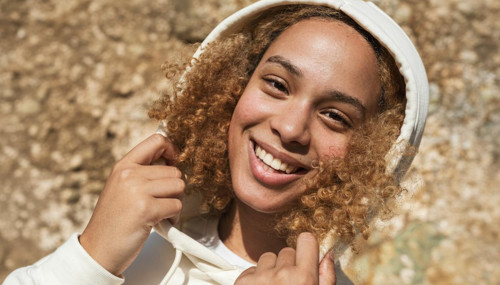

In [133]:
result, session_id = chat_completion(
    prompt="Generate a professional headshot using a Dutch Angle (Tilted Shot) camera angle. Tilt the camera to create a dynamic and slightly disorienting effect, adding energy and modern flair. The tilt should be subtle enough to maintain professionalism while adding visual interest.",
    images=[SOURCE_IMAGE_URL],
    response_model=GeneratedHeadshotResponse,
    model="vlmrun-orion-1:fast"
)

print(">> RESPONSE")
print(f"Generated headshot: {result.image}")
print(f"Description: {result.description}")

if hasattr(result.image, 'id'):
    image_path = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    if isinstance(image_path, Image.Image):
        generated_image = image_path
    else:
        generated_image = Image.open(image_path)
else:
    response = requests.get(result.image.url)
    generated_image = Image.open(BytesIO(response.content))
print(f"\n>> GENERATED HEADSHOT - Dutch Angle")
display_images([generated_image], texts=["13. Dutch Angle (Tilted Shot)"], width=500)


### 14. Low Angle

A low angle shot looks up at the subject from below, creating a sense of power, authority, and confidence. This is excellent for executive or leadership headshots.


>> RESPONSE
Generated headshot: id='img_2b1070'
Description: Here is your professional headshot, generated with a low-angle camera perspective to convey power, authority, and confidence, confidence, leadership, and strength.

>> GENERATED HEADSHOT - Low Angle



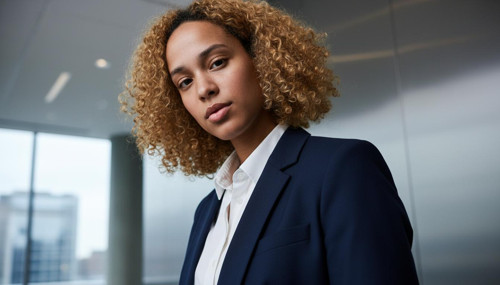

In [134]:
result, session_id = chat_completion(
    prompt="Generate a professional headshot using a Low Angle camera angle. Look up at the subject from below, creating a sense of power, authority, and confidence. This angle should convey leadership and strength, perfect for executive or professional headshots.",
    images=[SOURCE_IMAGE_URL],
    response_model=GeneratedHeadshotResponse,
    model="vlmrun-orion-1:fast"
)

print(">> RESPONSE")
print(f"Generated headshot: {result.image}")
print(f"Description: {result.description}")

if hasattr(result.image, 'id'):
    image_path = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    if isinstance(image_path, Image.Image):
        generated_image = image_path
    else:
        generated_image = Image.open(image_path)
else:
    response = requests.get(result.image.url)
    generated_image = Image.open(BytesIO(response.content))
print(f"\n>> GENERATED HEADSHOT - Low Angle")
display_images([generated_image], texts=["14. Low Angle"], width=500)


### 15. Worm's Eye View

A worm's eye view is an extreme low angle shot taken from ground level, looking straight up. This creates a dramatic and powerful perspective.


>> RESPONSE
Generated headshot: id='img_2d39b2'
Description: Here is your professional headshot using a Worm's Eye View camera angle. It's an extreme low angle shot taken from ground level, looking straight up, to create a dramatic and powerful perspective that emphasizes the subject's presence and authority. 

>> GENERATED HEADSHOT - Worm's Eye View



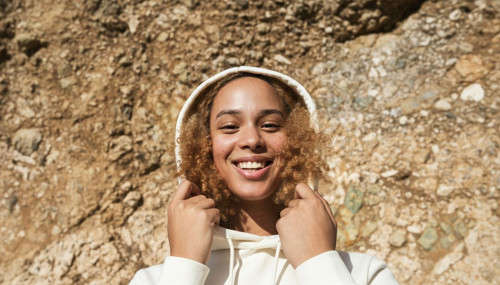

In [135]:
result, session_id = chat_completion(
    prompt="Generate a professional headshot using a Worm's Eye View camera angle. Use an extreme low angle shot taken from ground level, looking straight up. This creates a dramatic and powerful perspective that emphasizes the subject's presence and authority.",
    images=[SOURCE_IMAGE_URL],
    response_model=GeneratedHeadshotResponse,
    model="vlmrun-orion-1:fast"
)

print(">> RESPONSE")
print(f"Generated headshot: {result.image}")
print(f"Description: {result.description}")

if hasattr(result.image, 'id'):
    image_path = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    if isinstance(image_path, Image.Image):
        generated_image = image_path
    else:
        generated_image = Image.open(image_path)
else:
    response = requests.get(result.image.url)
    generated_image = Image.open(BytesIO(response.content))
print(f"\n>> GENERATED HEADSHOT - Worm's Eye View")
display_images([generated_image], texts=["15. Worm's Eye View"], width=500)


### 16. High Angle

A high angle shot looks down at the subject from above, creating a sense of vulnerability or approachability. This can be useful for creating more friendly and accessible professional headshots.


>> RESPONSE
Generated headshot: id='img_8b42df'
Description: I generated a professional headshot of you using a high-angle camera shot to create a sense of approachability and friendliness. I made sure to maintain professionalism while making you appear more accessible and welcoming.

>> GENERATED HEADSHOT - High Angle



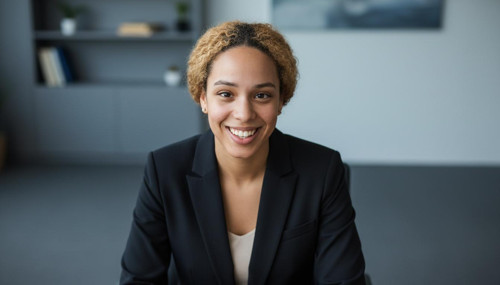

In [136]:
result, session_id = chat_completion(
    prompt="Generate a professional headshot using a High Angle camera angle. Look down at the subject from above, creating a sense of approachability and friendliness. This angle should make the subject appear more accessible and welcoming while maintaining professionalism.",
    images=[SOURCE_IMAGE_URL],
    response_model=GeneratedHeadshotResponse,
    model="vlmrun-orion-1:fast"
)

print(">> RESPONSE")
print(f"Generated headshot: {result.image}")
print(f"Description: {result.description}")

if hasattr(result.image, 'id'):
    image_path = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    if isinstance(image_path, Image.Image):
        generated_image = image_path
    else:
        generated_image = Image.open(image_path)
else:
    response = requests.get(result.image.url)
    generated_image = Image.open(BytesIO(response.content))
print(f"\n>> GENERATED HEADSHOT - High Angle")
display_images([generated_image], texts=["16. High Angle"], width=500)


### 17. Bird's Eye View

A bird's eye view is an extreme high angle shot taken from directly above, creating a unique and dramatic overhead perspective.


>> RESPONSE
Generated headshot: id='img_70cb59'
Description: Here is your professional headshot using a bird's eye view camera angle. I made sure to maintain your recognizable features while giving it a unique and modern overhead perspective.

>> GENERATED HEADSHOT - Bird's Eye View



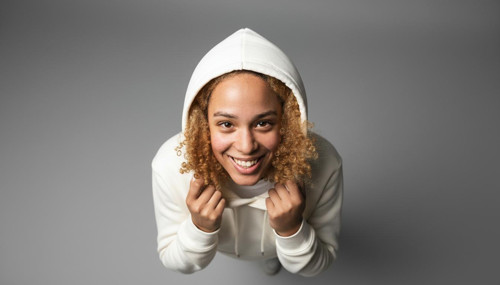

In [137]:
result, session_id = chat_completion(
    prompt="Generate a professional headshot using a Bird's Eye View camera angle. Use an extreme high angle shot taken from directly above, creating a unique and dramatic overhead perspective. This should create an interesting and modern professional headshot while maintaining the subject's recognizable features.",
    images=[SOURCE_IMAGE_URL],
    response_model=GeneratedHeadshotResponse,
    model="vlmrun-orion-1:fast"
)

print(">> RESPONSE")
print(f"Generated headshot: {result.image}")
print(f"Description: {result.description}")

if hasattr(result.image, 'id'):
    image_path = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    if isinstance(image_path, Image.Image):
        generated_image = image_path
    else:
        generated_image = Image.open(image_path)
else:
    response = requests.get(result.image.url)
    generated_image = Image.open(BytesIO(response.content))
print(f"\n>> GENERATED HEADSHOT - Bird's Eye View")
display_images([generated_image], texts=["17. Bird's Eye View"], width=500)


### 18. Eye-Level Shot

An eye-level shot positions the camera at the same height as the subject's eyes, creating a natural and balanced perspective. This is the most common and versatile professional headshot angle.


>> RESPONSE
Generated headshot: id='img_0eb86c'
Description: Here is your professional headshot, img_0eb86c, taken with an eye-level shot to provide a natural and balanced perspective. The subject is smiling and dressed in professional attire against a clean, professional background, perfect for corporate and business use.

>> GENERATED HEADSHOT - Eye-Level Shot



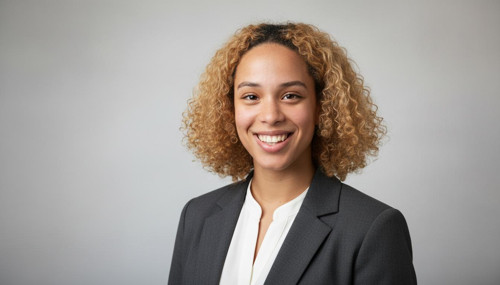

In [138]:
result, session_id = chat_completion(
    prompt="Generate a professional headshot using an Eye-Level Shot camera angle. Position the camera at the same height as the subject's eyes, creating a natural and balanced perspective. This is the most common and versatile professional headshot angle, perfect for corporate and business use.",
    images=[SOURCE_IMAGE_URL],
    response_model=GeneratedHeadshotResponse,
    model="vlmrun-orion-1:fast"
)

print(">> RESPONSE")
print(f"Generated headshot: {result.image}")
print(f"Description: {result.description}")

if hasattr(result.image, 'id'):
    image_path = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    if isinstance(image_path, Image.Image):
        generated_image = image_path
    else:
        generated_image = Image.open(image_path)
else:
    response = requests.get(result.image.url)
    generated_image = Image.open(BytesIO(response.content))
print(f"\n>> GENERATED HEADSHOT - Eye-Level Shot")
display_images([generated_image], texts=["18. Eye-Level Shot"], width=500)


### 19. Pedestal Shot

A pedestal shot involves moving the camera vertically up or down while keeping the same framing. For a headshot, this creates a smooth, professional transition effect.


>> RESPONSE
Generated headshot: id='img_2c5303'
Description: Here are two headshots with a 1:1 aspect ratio, from different viewpoints.

>> GENERATED HEADSHOT - Pedestal Shot



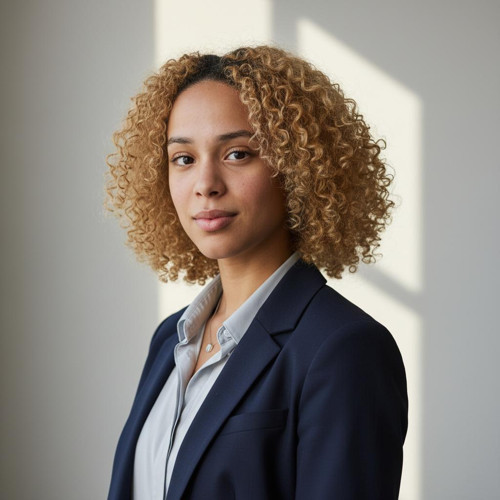

In [139]:
result, session_id = chat_completion(
    prompt="Create a photorealistic professional pedestal headshot of the person in the reference image. Neutral background, natural lighting, crisp detail, flattering portrait style. Have professional clothing and have her look straight at the camera. generate 2 different viewpoints, and each in 1:1 and 3:4 aspect ratio respectively.",
    images=[SOURCE_IMAGE_URL],
    response_model=GeneratedHeadshotResponse,
    model="vlmrun-orion-1:fast"
)

print(">> RESPONSE")
print(f"Generated headshot: {result.image}")
print(f"Description: {result.description}")

if hasattr(result.image, 'id'):
    image_path = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    if isinstance(image_path, Image.Image):
        generated_image = image_path
    else:
        generated_image = Image.open(image_path)
else:
    response = requests.get(result.image.url)
    generated_image = Image.open(BytesIO(response.content))
print(f"\n>> GENERATED HEADSHOT - Pedestal Shot")
display_images([generated_image], texts=["19. Pedestal Shot"], width=500)


---

## Conclusion

This cookbook demonstrated how to generate professional headshots using **VLM Run Orion Agent API** with 19 different camera angles and perspectives.

### Key Takeaways

1. **OpenAI-Compatible Interface**: The API follows the OpenAI chat completions format, making it easy to integrate with existing workflows and tools.
2. **Structured Outputs**: Use Pydantic models with `response_model` parameter to get type-safe, validated responses with automatic parsing.
3. **Camera Angle Variety**: Each camera angle creates a different visual effect and conveys different emotions or professional contexts.
4. **Professional Quality**: All generated headshots maintain professional lighting, composition, and styling appropriate for business use.
5. **Flexible Prompting**: Natural language prompts allow you to specify exact camera angles and desired effects.

### Camera Angles Summary

| Angle | Effect | Best For |
|-------|--------|----------|
| **Long Shot** | Shows full body, provides context | Environmental portraits |
| **Medium Shot** | Balanced composition, waist up | General professional headshots |
| **Close-Up** | Intimate, emphasizes features | Personal branding |
| **POV** | Immersive, unique perspective | Creative portfolios |
| **Cowboy Angle** | Strong, confident look | Leadership positions |
| **Hip Level** | Natural, approachable | Friendly professional image |
| **Knee Level** | Wider view, maintains focus | Versatile professional use |
| **Tracking Shot** | Dynamic movement, energy | Modern, creative industries |
| **Shoulder Level** | Intimate, focused | Corporate headshots |
| **Telephoto** | Compressed background, shallow DOF | Standout portraits |
| **Macro** | Extreme detail, artistic | Creative/artistic portfolios |
| **Wide-Angle** | Sense of space, context | Environmental context |
| **Dutch Angle** | Dynamic, modern flair | Creative industries |
| **Low Angle** | Power, authority | Executive/leadership |
| **Worm's Eye** | Dramatic, powerful | Strong presence needed |
| **High Angle** | Approachable, friendly | Accessible professional image |
| **Bird's Eye** | Unique overhead perspective | Creative/artistic use |
| **Eye-Level** | Natural, balanced | Most versatile, standard use |
| **Pedestal** | Smooth vertical motion | Modern professional portfolios |

### Next Steps

- Explore the [VLM Run Documentation](https://docs.vlm.run) for more details
- Check out the [Image Generation Guide](https://docs.vlm.run/agents/capabilities/image) for advanced features
- Join our [Discord community](https://discord.gg/AMApC2UzVY) for support
- Check out more examples in the [VLM Run Cookbook](https://github.com/vlm-run/vlmrun-cookbook)

Happy building!
